# Heart Failure Analysis

### Imports

In [154]:
# Imports the necessary packages
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Loading the Data

In [155]:
df = pl.read_csv(
    "data/heart_failure_clinical_records_dataset.csv.xls", 
    schema={
        "age": pl.Float32,
        "anaemia": pl.Int32,
        "creatinine_phosphokinase": pl.Int32,
        "diabetes": pl.Int32,
        "ejection_fraction": pl.Int32,
        "high_blood_pressure": pl.Int32,
        "platelets": pl.Float64,
        "serum_creatinine": pl.Float64,
        "serum_sodium": pl.Int32,
        "sex": pl.Int32,
        "smoking": pl.Int32,
        "time": pl.Int32,
        "DEATH_EVENT": pl.Int32
    }
)

In [156]:
df.describe()

statistic,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",60.833893,0.431438,581.839465,0.41806,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.26087,0.32107
"""std""",11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
"""min""",40.0,0.0,23.0,0.0,14.0,0.0,25100.0,0.5,113.0,0.0,0.0,4.0,0.0
"""25%""",51.0,0.0,118.0,0.0,30.0,0.0,213000.0,0.9,134.0,0.0,0.0,73.0,0.0
"""50%""",60.0,0.0,250.0,0.0,38.0,0.0,262000.0,1.1,137.0,1.0,0.0,115.0,0.0
"""75%""",70.0,1.0,582.0,1.0,45.0,1.0,304000.0,1.4,140.0,1.0,1.0,205.0,1.0
"""max""",95.0,1.0,7861.0,1.0,80.0,1.0,850000.0,9.4,148.0,1.0,1.0,285.0,1.0


### Preparing the data

In [157]:
# Checks for null values
null_check = df.null_count()
print(null_check)

shape: (1, 13)
┌─────┬─────────┬──────────────────────────┬──────────┬───┬─────┬─────────┬──────┬─────────────┐
│ age ┆ anaemia ┆ creatinine_phosphokinase ┆ diabetes ┆ … ┆ sex ┆ smoking ┆ time ┆ DEATH_EVENT │
│ --- ┆ ---     ┆ ---                      ┆ ---      ┆   ┆ --- ┆ ---     ┆ ---  ┆ ---         │
│ u32 ┆ u32     ┆ u32                      ┆ u32      ┆   ┆ u32 ┆ u32     ┆ u32  ┆ u32         │
╞═════╪═════════╪══════════════════════════╪══════════╪═══╪═════╪═════════╪══════╪═════════════╡
│ 0   ┆ 0       ┆ 0                        ┆ 0        ┆ … ┆ 0   ┆ 0       ┆ 0    ┆ 0           │
└─────┴─────────┴──────────────────────────┴──────────┴───┴─────┴─────────┴──────┴─────────────┘


In [158]:
# A couple ages are floats. We will round them and convert the column to integers.
df = df.with_columns(
    df["age"].round().alias("age").cast(pl.Int32)
)

### EDA

In [159]:
# Calculates correlation matrix
corr_matrix = df.select(pl.col(pl.NUMERIC_DTYPES)).corr()

# Easier for labeling
corr_matrix = corr_matrix.to_pandas()

# Labeling for graphs
corr_matrix.columns = df.columns
corr_matrix.index = df.columns
corr_matrix

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088222,-0.081672,-0.100791,0.060049,0.093347,-0.052294,0.159161,-0.045992,0.065371,0.018539,-0.223969,0.253800
anaemia,0.088222,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081672,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.100791,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060049,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093347,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052294,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159161,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045992,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065371,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


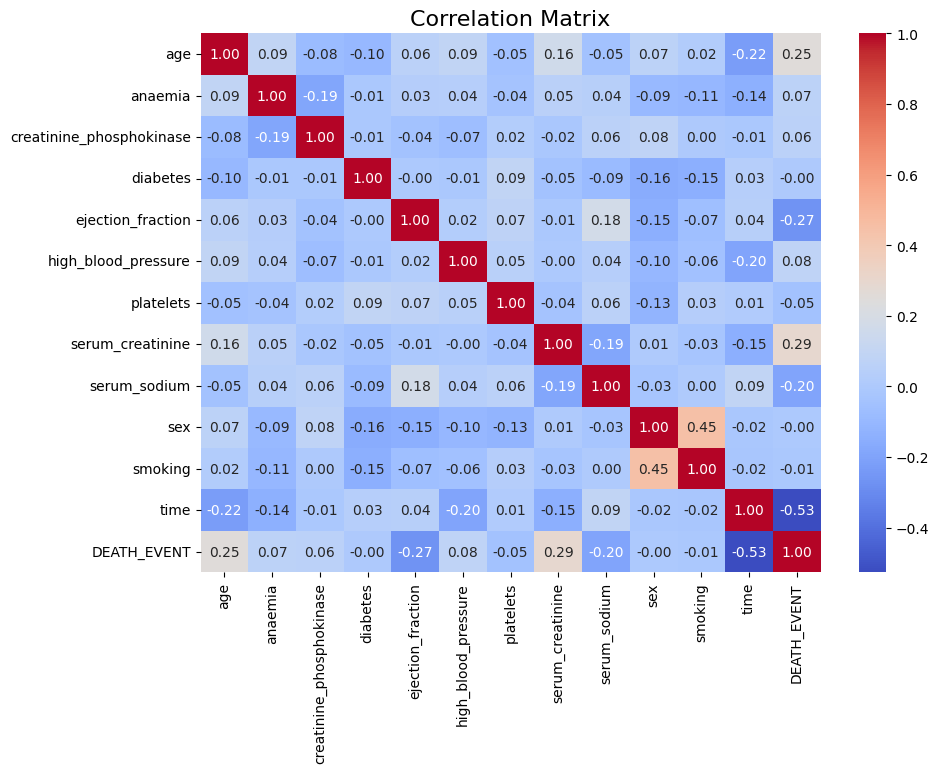

In [160]:
# Plots heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

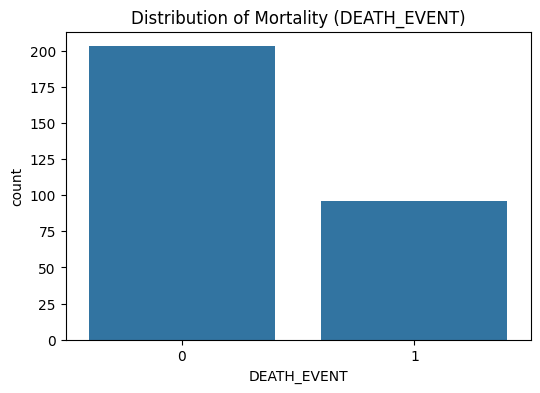

In [161]:
# Visualize the distribution of the target variable (DEATH_EVENT)
plt.figure(figsize=(6, 4))
sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Distribution of Mortality (DEATH_EVENT)')
plt.show()

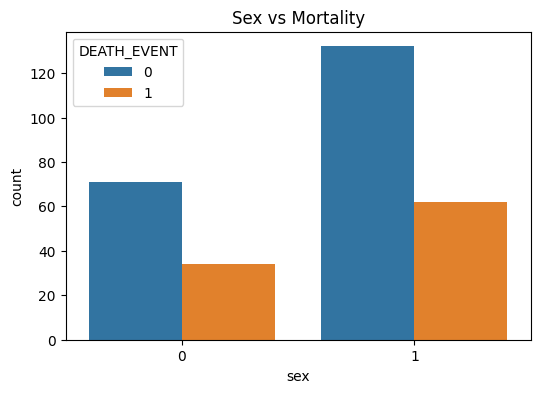

In [162]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', hue='DEATH_EVENT', data=df)
plt.title('Sex vs Mortality')
plt.show()

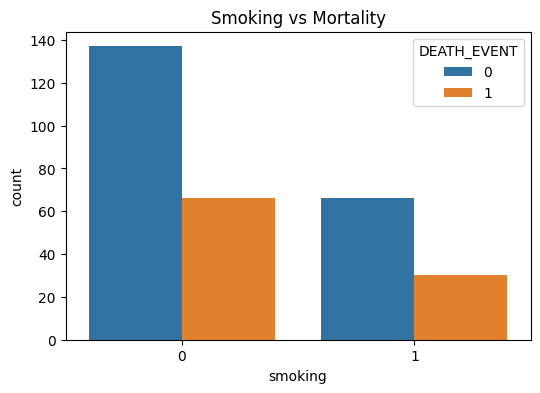

In [163]:
# Visualizing the relationship between 'smoking' and mortality
plt.figure(figsize=(6, 4))
sns.countplot(x='smoking', hue='DEATH_EVENT', data=df)
plt.title('Smoking vs Mortality')
plt.show()

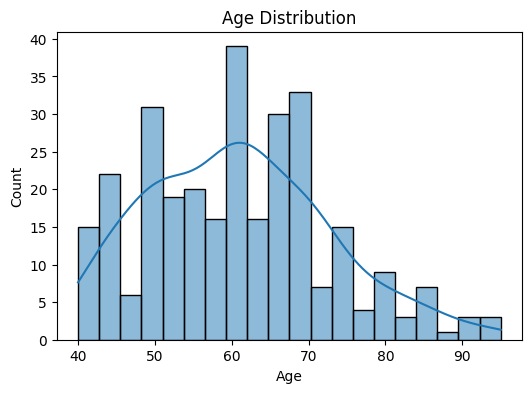

In [177]:
# Plotting the distribution of age (numeric feature)
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.xlabel("Age")
plt.show()

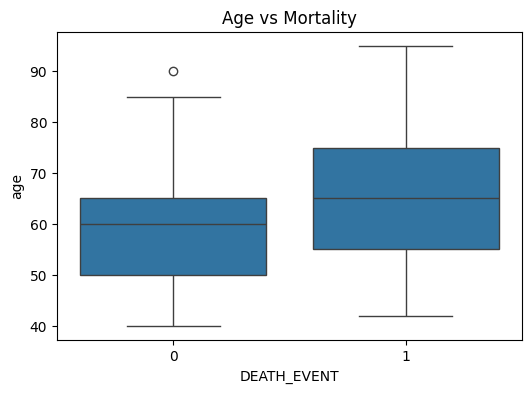

In [165]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='DEATH_EVENT', y='age', data=df)
plt.title('Age vs Mortality')
plt.show()

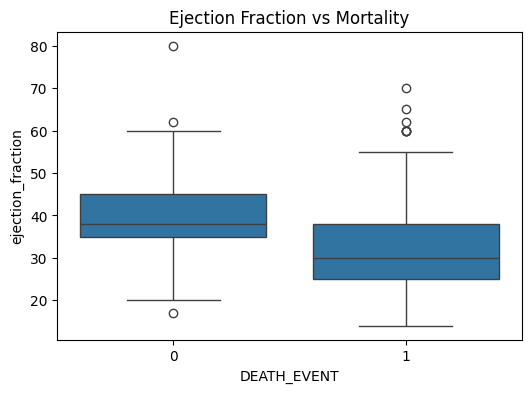

In [166]:
# Boxplot for 'ejection_fraction' by mortality
plt.figure(figsize=(6, 4))
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)
plt.title('Ejection Fraction vs Mortality')
plt.show()

### Modeling

In [168]:
# Split data into features and target
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']

/var/folders/x7/qrnrw4rd6jlbxb3n07zps4vh0000gn/T/ipykernel_3609/800573022.py:2: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  X = df.drop(columns=['DEATH_EVENT'])


In [169]:
# Standardize the features (important for models like Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [170]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [171]:
# Logistic Regression
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [172]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [173]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [174]:
logreg_preds = logreg_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

In [175]:
def evaluate_model(model_name, y_true, y_pred):
    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortality', 'Mortality'], yticklabels=['No Mortality', 'Mortality'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Logistic Regression - Evaluation Metrics:
Accuracy: 0.8000
Precision: 0.9333
Recall: 0.5600
F1-Score: 0.7000
[[34  1]
 [11 14]]


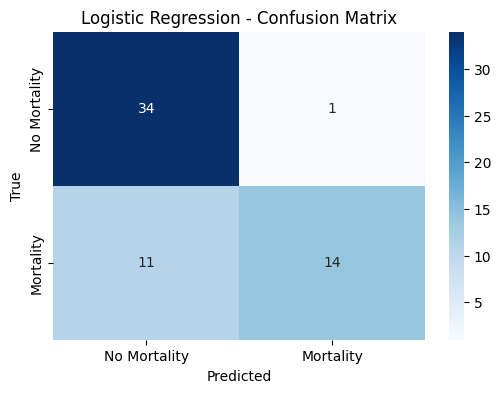


Random Forest - Evaluation Metrics:
Accuracy: 0.7500
Precision: 0.8571
Recall: 0.4800
F1-Score: 0.6154
[[33  2]
 [13 12]]


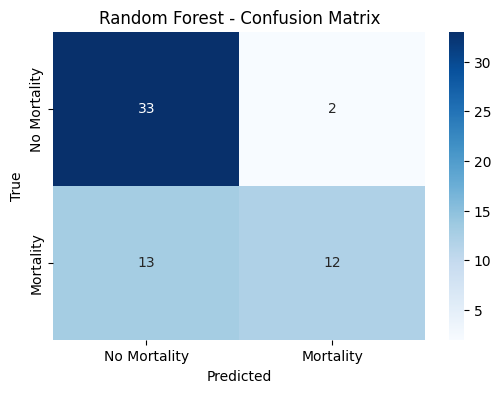


XGBoost - Evaluation Metrics:
Accuracy: 0.7667
Precision: 0.7895
Recall: 0.6000
F1-Score: 0.6818
[[31  4]
 [10 15]]


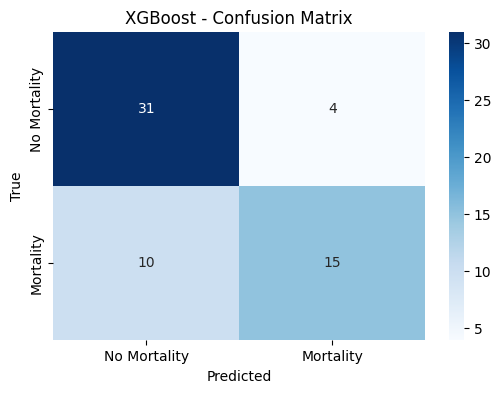

In [176]:
evaluate_model("Logistic Regression", y_test, logreg_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)